In [75]:
import pickle
import numpy as np
import os
import data_utils
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
cifar10_dir = 'datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = data_utils.load_CIFAR10(cifar10_dir)

print(f'Training data shape: {X_train.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Test data shape: {X_test.shape}')
print(f'Test labels shape: {y_test.shape}')

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


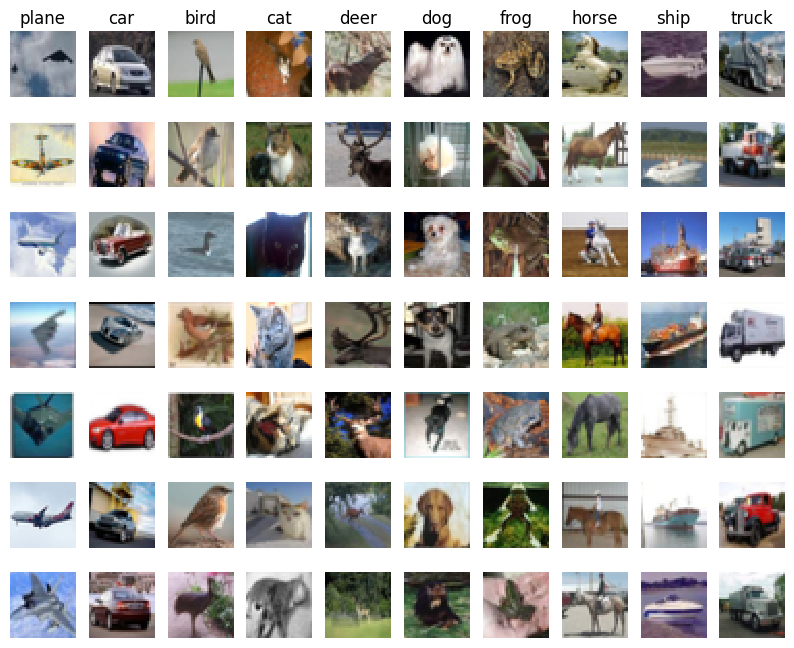

In [77]:
# Visualize some examples from the dataset
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()


In [78]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [79]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [80]:
from classifiers.k_nearest_neighbor import KNearestNeighbor

# Create a kNN classifier instance.
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [81]:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


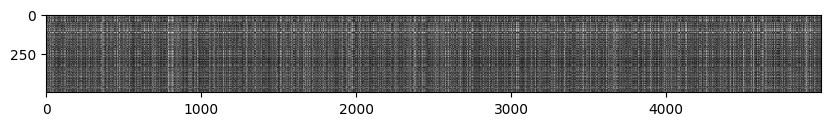

In [82]:
plt.imshow(dists, interpolation='none')
plt.show()

In [83]:
y_test_pred = classifier.predict_labels(dists, k=1)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test

print(f'Got {num_correct}/{num_test} correct => accuracy: {accuracy}')

Got 137/500 correct => accuracy: 0.274


In [84]:
y_test_pred = classifier.predict_labels(dists, k=5)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test

print(f'Got {num_correct}/{num_test} correct => accuracy: {accuracy}')

Got 139/500 correct => accuracy: 0.278


In [85]:
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [86]:
dists_one = classifier.compute_distances_one_loop(X_test)
difference = np.linalg.norm(dists - dists_one, ord='fro')
print(f'Difference was: {difference}')
if difference < 0.001:
    print("Good! The distance matrices are the same")
else:
    print("Uh-oh! The distance matrices are different")

Difference was: 0.0
Good! The distance matrices are the same


In [87]:
dists_one = classifier.compute_distances_no_loops(X_test)
difference = np.linalg.norm(dists - dists_one, ord='fro')
print(f'Difference was: {difference}')
if difference < 0.001:
    print("Good! The distance matrices are the same")
else:
    print("Uh-oh! The distance matrices are different")

Difference was: 0.0
Good! The distance matrices are the same


In [88]:
def time_function(f, *args):
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print(f'Two loop version took {two_loop_time} seconds')

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print(f'Two loop version took {one_loop_time} seconds')

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print(f'Two loop version took {no_loop_time} seconds')

Two loop version took 12.403639078140259 seconds
Two loop version took 9.317634105682373 seconds
Two loop version took 0.16900873184204102 seconds


In [105]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

k_to_accuracies = {}



In [113]:
for k in k_choices:
    k_to_accuracies[k] = []
    for fold in range(num_folds):
        all_folds = list(range(num_folds))
        val_fold = fold
        all_folds.pop(fold)
        train_folds = all_folds
        X_val = X_train_folds[val_fold]
        y_val = y_train_folds[val_fold]

        X_new_train = np.concatenate([X_train_folds[i] for i in train_folds])
        y_new_train = np.concatenate([y_train_folds[i] for i in train_folds])

        # Create a kNN classifier instance.
        classifier = KNearestNeighbor()
        classifier.train(X_new_train, y_new_train)

        y_test_pred = classifier.predict(X_val, k=k)
        num_correct = np.sum(y_test_pred == y_val)
        accuracy = (float(num_correct) / num_test)*100.0

        k_to_accuracies[k].append(accuracy)

        #print(accuracy)
        

In [115]:
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print(f'k = {k}, accuracy = {accuracy:.2f}')

k = 1, accuracy = 52.60
k = 1, accuracy = 51.40
k = 1, accuracy = 52.80
k = 1, accuracy = 55.60
k = 1, accuracy = 53.20
k = 3, accuracy = 47.80
k = 3, accuracy = 49.80
k = 3, accuracy = 48.00
k = 3, accuracy = 53.20
k = 3, accuracy = 50.80
k = 5, accuracy = 49.60
k = 5, accuracy = 53.20
k = 5, accuracy = 56.00
k = 5, accuracy = 58.40
k = 5, accuracy = 56.00
k = 8, accuracy = 52.40
k = 8, accuracy = 56.40
k = 8, accuracy = 54.60
k = 8, accuracy = 58.00
k = 8, accuracy = 54.60
k = 10, accuracy = 53.00
k = 10, accuracy = 59.20
k = 10, accuracy = 55.20
k = 10, accuracy = 56.80
k = 10, accuracy = 56.00
k = 12, accuracy = 52.00
k = 12, accuracy = 59.00
k = 12, accuracy = 55.80
k = 12, accuracy = 56.60
k = 12, accuracy = 56.00
k = 15, accuracy = 50.40
k = 15, accuracy = 57.80
k = 15, accuracy = 55.60
k = 15, accuracy = 56.40
k = 15, accuracy = 54.80
k = 20, accuracy = 54.00
k = 20, accuracy = 55.80
k = 20, accuracy = 55.80
k = 20, accuracy = 56.40
k = 20, accuracy = 57.00
k = 50, accuracy = 5

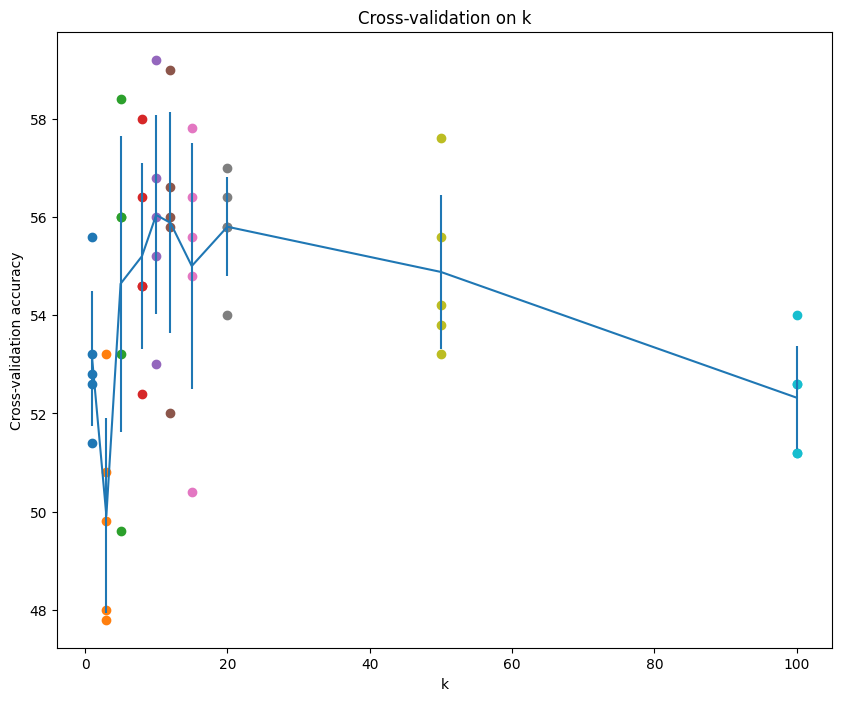

In [118]:
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [121]:
best_k = k_choices[np.argmax(accuracies_mean)]

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

num_correct = np.sum(y_test_pred == y_test)
accuracy = (float(num_correct) / num_test) * 100.0
print(f'Got {num_correct}/{num_test} correct => accuracy: {accuracy}')

Got 141/500 correct => accuracy: 28.199999999999996


In [123]:
0.25**2 *4

0.25

In [126]:
-np.log(1/5.0)

1.6094379124341003

In [127]:
np.log10(1/5.0)

-0.6989700043360187